In [2]:
train_dir = "/kaggle/input/dataset/real_vs_fake/real-vs-fake/train"
val_dir = "/kaggle/input/dataset/real_vs_fake/real-vs-fake/valid"
test_dir = "/kaggle/input/dataset/real_vs_fake/real-vs-fake/test"

In [5]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Normalize and augment
train_datagen = ImageDataGenerator(rescale=1./255, rotation_range=20, zoom_range=0.2, horizontal_flip=True)
val_datagen = ImageDataGenerator(rescale=1./255)

# Load images from directories
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(160, 160),
    batch_size=32,
    class_mode='binary'
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(160, 160),
    batch_size=32,
    class_mode='binary'
)

2025-06-17 17:08:14.230845: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1750180094.436850      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1750180094.496488      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Found 100000 images belonging to 2 classes.
Found 20000 images belonging to 2 classes.


In [7]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense,GlobalAveragePooling2D,Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf


base_model=MobileNetV2(input_shape=(160,160,3),include_top=False,weights='imagenet')
base_model.trainable=False


x=base_model.output
x=GlobalAveragePooling2D()(x)
x=Dense(160,activation='relu')(x)
prediction=Dense(1,activation='sigmoid')(x)

model=Model(inputs=base_model.input, outputs=prediction)



model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

early_stop=EarlyStopping(monitor='val_loss',patience=3,restore_best_weights=True)

history=model.fit(
    train_generator,
    epochs=10,
    validation_data=val_generator,
    callbacks=[early_stop]
)

Epoch 1/10
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 1580s 503ms/step - accuracy: 0.7194 - loss: 0.5486 - val_accuracy: 0.7845 - val_loss: 0.4584
Epoch 2/10
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 785s 251ms/step - accuracy: 0.7739 - loss: 0.4718 - val_accuracy: 0.7951 - val_loss: 0.4416
Epoch 3/10
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 682s 218ms/step - accuracy: 0.7919 - loss: 0.4439 - val_accuracy: 0.8059 - val_loss: 0.4241
Epoch 4/10
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 666s 213ms/step - accuracy: 0.8014 - loss: 0.4290 - val_accuracy: 0.8037 - val_loss: 0.4276
Epoch 5/10
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 686s 219ms/step - accuracy: 0.8056 - loss: 0.4182 - val_accuracy: 0.8073 - val_loss: 0.4202
Epoch 6/10
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 706s 226ms/step - accuracy: 0.8131 - loss: 0.4077 - val_accuracy: 0.8114 - val_loss: 0.4107
Epoch 7/10
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 698s 223ms/step - accuracy: 0.8184 - loss: 0.3974 - val_accuracy: 0.8150 - val_loss: 0.4083
Epoch 8/10
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 673s 215ms/step - a

In [8]:
model.save("ai_detector.keras")  # New standard format


In [10]:
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(160, 160),
    batch_size=32,
    class_mode='binary',
    shuffle=False
)

Found 20000 images belonging to 2 classes.


In [34]:
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


model = load_model('ai_detector.keras')


set_trainable = False
for layer in model.layers:
    if layer.name == "block_13_expand":
        set_trainable = True
    layer.trainable = set_trainable

model.compile(
    optimizer=Adam(learning_rate=1e-5), 
    loss='binary_crossentropy',
    metrics=['accuracy']
)


IMG_SIZE = (160, 160)
BATCH_SIZE = 32


train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest"
)

val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary'
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary'
)


early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
checkpoint = ModelCheckpoint("finetuned_ai_detector.keras", save_best_only=True)


history = model.fit(
    train_generator,
    epochs=10,
    validation_data=val_generator,
    callbacks=[early_stop, checkpoint]
)


model.save("finetuned_ai_detector.keras")


✅ Model loaded.
Found 100000 images belonging to 2 classes.
Found 20000 images belonging to 2 classes.
Epoch 1/10


E0000 00:00:1750194618.557333     109 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1750194618.753997     109 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


3125/3125 ━━━━━━━━━━━━━━━━━━━━ 691s 214ms/step - accuracy: 0.6908 - loss: 0.7822 - val_accuracy: 0.7804 - val_loss: 0.4917
Epoch 2/10
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 683s 219ms/step - accuracy: 0.8035 - loss: 0.4282 - val_accuracy: 0.8352 - val_loss: 0.3717
Epoch 3/10
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 691s 221ms/step - accuracy: 0.8313 - loss: 0.3742 - val_accuracy: 0.8554 - val_loss: 0.3375
Epoch 4/10
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 718s 230ms/step - accuracy: 0.8572 - loss: 0.3306 - val_accuracy: 0.8785 - val_loss: 0.2929
Epoch 5/10
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 718s 230ms/step - accuracy: 0.8689 - loss: 0.3053 - val_accuracy: 0.8845 - val_loss: 0.2805
Epoch 6/10
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 706s 226ms/step - accuracy: 0.8790 - loss: 0.2823 - val_accuracy: 0.8898 - val_loss: 0.2672
Epoch 7/10
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 743s 238ms/step - accuracy: 0.8898 - loss: 0.2624 - val_accuracy: 0.8955 - val_loss: 0.2562
Epoch 8/10
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 761s 243ms/step - accuracy: 0.8

625/625 ━━━━━━━━━━━━━━━━━━━━ 51s 81ms/step


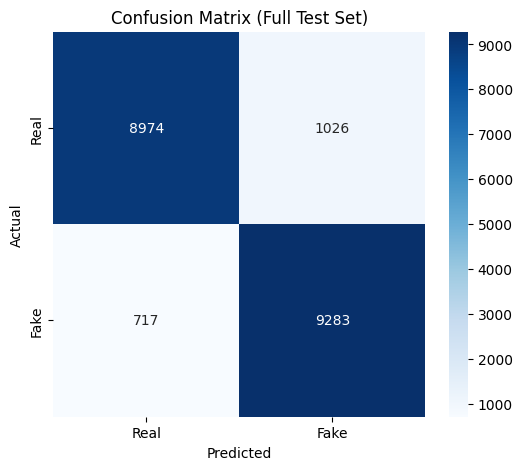

Classification Report:

              precision    recall  f1-score   support

        Real       0.93      0.90      0.91     10000
        Fake       0.90      0.93      0.91     10000

    accuracy                           0.91     20000
   macro avg       0.91      0.91      0.91     20000
weighted avg       0.91      0.91      0.91     20000



In [36]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt


probs = model.predict(test_generator)
preds = (probs > 0.5).astype("int32").flatten()


true_labels = test_generator.classes


cm = confusion_matrix(true_labels, preds)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Real", "Fake"], yticklabels=["Real", "Fake"])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (Full Test Set)')
plt.show()

# Classification Report
print("Classification Report:\n")
print(classification_report(true_labels, preds, target_names=["Real", "Fake"]))


In [1]:
from tensorflow.keras.models import load_model

model_path = "/kaggle/input/detector/keras/default/1/finetuned_ai_detector.keras"
model = load_model(model_path)
print("Model loaded!")

2025-06-20 18:20:46.770970: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1750443646.990048      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1750443647.047103      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
I0000 00:00:1750443660.280624      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


Model loaded!


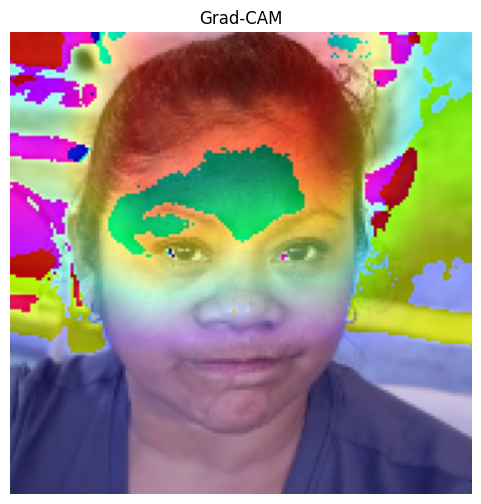

In [10]:
last_conv_layer_name = "Conv_1"

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import cv2

def get_img_array(img_path, size):
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=size)
    array = tf.keras.preprocessing.image.img_to_array(img)
    array = np.expand_dims(array, axis=0)
    return tf.keras.applications.mobilenet_v2.preprocess_input(array)

def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    grad_model = tf.keras.models.Model(
        [model.inputs], 
        [model.get_layer(last_conv_layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(predictions[0])
        class_channel = predictions[:, pred_index]

    grads = tape.gradient(class_channel, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()


def display_gradcam(img_path, heatmap, alpha=0.4):
    img = cv2.imread(img_path)
    img = cv2.resize(img, (160, 160))  # match model input

    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

    superimposed_img = heatmap * alpha + img
    superimposed_img = np.uint8(superimposed_img)

    plt.figure(figsize=(6, 6))
    plt.imshow(cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.title("Grad-CAM")
    plt.show()

img_path = "/kaggle/input/dataset/real_vs_fake/real-vs-fake/train/real/00002.jpg"
img_array = get_img_array(img_path, size=(160, 160))

heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name="Conv_1")
display_gradcam(img_path, heatmap)

In [2]:
model.save("/kaggle/working/finetuned_ai_detector.h5")

In [8]:
import tensorflow as tf
model=tf.keras.models.load_model("/kaggle/input/detector/keras/default/1/finetuned_ai_detector.keras")

I0000 00:00:1750584191.360480      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


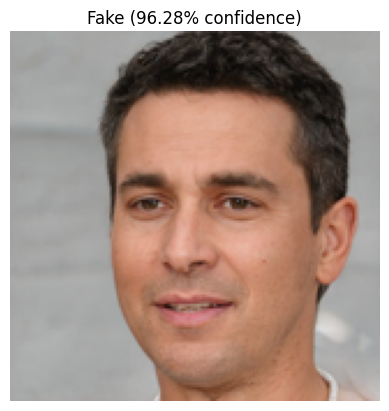

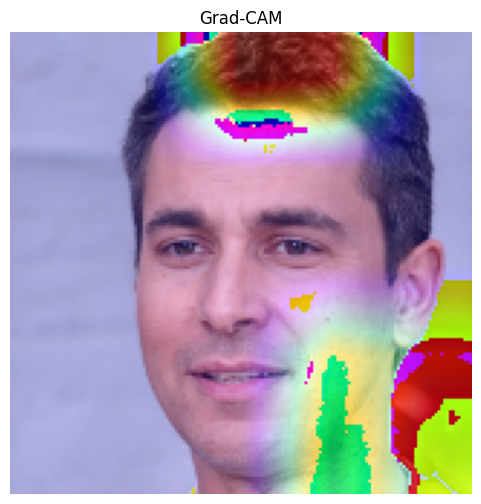

In [44]:
from PIL import Image
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os


imgs="/kaggle/input/jmghjxfg/v3_0261429.jpg"
image=Image.open(imgs)
image=image.resize((160,160))
image_array= tf.keras.preprocessing.image.img_to_array(image)/255.0
img_array=np.expand_dims(image_array,axis=0)


prediction=model.predict(img_array)[0][0]

label='Real' if prediction>0.5 else 'Fake'
confidence= prediction if prediction>0.5 else 1-prediction

plt.imshow(image)
plt.axis('off')
plt.title(f"{label} ({confidence:.2%} confidence)")
plt.show()
last_conv_layer_name = "Conv_1"

import cv2



def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    grad_model = tf.keras.models.Model(
        [model.inputs], 
        [model.get_layer(last_conv_layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(predictions[0])
        class_channel = predictions[:, pred_index]

    grads = tape.gradient(class_channel, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()


def display_gradcam(img_path, heatmap, alpha=0.4):
    img = cv2.imread(img_path)
    img = cv2.resize(img, (160, 160))  # match model input

    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

    superimposed_img = heatmap * alpha + img
    superimposed_img = np.uint8(superimposed_img)

    plt.figure(figsize=(6, 6))
    plt.imshow(cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.title("Grad-CAM")
    plt.show()

heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name="Conv_1")
display_gradcam(imgs, heatmap)
